Using cross validation to identify the best classifer for the dataset with new features

In [0]:
features  = ['PAY_JULY',
 'PAY_2',
 'Balance_Limit_Enc',
 'PAY_7',
 'PAY_3',
 'PAY_1',
 'PAY_0',
 'PAID_AMT_SEP',
 'PAID_AMT_NOV',
 'PAID_AMT_JULY',
 'PAID_AMT_DEC',
 'PAID_AMT_AUG']

Evaluation method

In [0]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

credit_card_default_train=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_train.csv')
credit_card_default_test=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

In [0]:
credit_card_default_train=pd.read_csv('/content/data/credit_card_default_train.csv')
# credit_card_default_test=pd.read_csv('/kaggle/input/data-storm-10/credit_card_default_test.csv')

In [0]:
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score    
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest,chi2,RFE,SelectFromModel
from lightgbm import LGBMClassifier
import itertools
from numpy import median


In [0]:
target_names = ['0','1']

def print_report(X_train, X_val, y_train, y_val, model):
    print('Train Report')
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train, target_names = target_names))

    print('Validation Report')
    y_pred_val = model.predict(X_val)
    print(classification_report(y_val, y_pred_val, target_names = target_names))
    
    print('Training f1-score(weighted): %f' % f1_score(y_train, y_pred_train, average = 'weighted'))
    print('Validation f1-score(weighted): %f' % f1_score(y_val, y_pred_val, average = 'weighted'))

In [0]:
_id = 'Client_ID'
target = 'NEXT_MONTH_DEFAULT'

X = credit_card_default_train.drop(target, axis =1)
y = credit_card_default_train.loc[:, target]


X.drop(_id, axis = 1, inplace = True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_copy= X_train.copy()
X_val_copy = X_val.copy()

In [0]:
unused_cols = ['Balance_Limit_V1', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']
pay_cols = ['PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']
paid_cols = ['PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
due_cols = ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC']
categorical_cols = ['EDU_ENC', 'MARITAL_ENC', 'AGE_ENC', 'Gender']

In [0]:
def balance_limit_encoder(value):
    last = value[-1]
    value = value[:-1]
    int_val = 0
    if last == 'K':
        int_val = float(value) * 1e3
    elif last == 'M':
        int_val = float(value) * 1e6
    return int_val/1e6
    
marital_status_encoder = LabelEncoder()
edu_status_encoder = LabelEncoder()
age_encoder = LabelEncoder()

def balance_limit_to_num(dataset):
    return dataset.assign(Balance_Limit_Enc = dataset['Balance_Limit_V1'].map(balance_limit_encoder))

def func_age_encode(data):
  if(data == '31-45'):
    return (31+45)/2
  elif data == 'Less than 30':
    return 15
  elif data == '46-65':
    return (65-46)/2
  elif data == 'More than 65':
    return 65
  else:
    return 0

# Fit Encoders
def fit_encoders(fit_data):
    marital_status_encoder.fit(fit_data['MARITAL_STATUS'])
    edu_status_encoder.fit(fit_data['EDUCATION_STATUS'])
    age_encoder.fit(fit_data['AGE'])


In [0]:
scaler = StandardScaler()

In [0]:
def generate_pay_value_frequency_features(dataset):
    '''Generates a column for each of the possible values for PAY_* columns with the frequency of
    each value in  a row'''

    cols = {'PAY_'+str(i) : [] for i in range(-2,10)}

    for index, row in dataset.iterrows():
        counts = {i : 0 for i in range(-2,10)}
      
        for i in pay_cols:
            item = int(row[i])
            counts[item] = counts.get(item, 0) + 1
        for key, value in counts.items():
            cols['PAY_'+str(key)].append(value)
    return pd.DataFrame(cols, index = dataset.index)

def generate_pay_due_diff_features(dataset):
    '''For each month in a row generate a column with the difference of the due and
    paid amount'''
    
    for col in paid_cols:
        dataset[col[9:]] = dataset[col] - dataset['DUE_AMT' + col[8:]]
        
interaction_encoders =[]

# Code modified from kaggle course 'Feature Generation'
def generate_interaction_features(dataset, train):
    global interaction_encoders
    
    if (train): interaction_encoders = []
    
    interactions = pd.DataFrame(index = dataset.index)
    i = 0
    for col1, col2 in itertools.combinations(categorical_cols, 2):
        new_col_name = '_'.join([col1, col2])
        new_values = dataset[col1].map(str) + "_" + dataset[col2].map(str)
        
        if (train):
            label_enc = LabelEncoder()
            interaction_encoders.append(label_enc)
            interactions[new_col_name] = label_enc.fit_transform(new_values)
        else:
            label_enc = interaction_encoders[i]
            interactions[new_col_name] = label_enc.transform(new_values)
            i+=1

    dataset = dataset.join(interactions) 
    return dataset

In [0]:
# Transform Categorical Data
def preprocess(data, train = False):
    dataset = data.copy()
    
    dataset = balance_limit_to_num(dataset)
    
    dataset['Gender'] = dataset.Gender.map(lambda x: 1 if x== 'M' else 0)
    dataset['AGE_ENC'] = dataset.AGE.map(func_age_encode)
    dataset['EDU_ENC'] = pd.Series(
        edu_status_encoder.transform(dataset['EDUCATION_STATUS']),
        dataset.index
    )
    
    dataset['MARITAL_ENC'] = pd.Series(
        marital_status_encoder.transform(dataset['MARITAL_STATUS']),
        dataset.index
    )
    
    generate_pay_due_diff_features(dataset)
    df = generate_pay_value_frequency_features(dataset)
    dataset = pd.concat([df, dataset], axis = 1)
   
    dataset = generate_interaction_features(dataset, train)
    dataset.drop(unused_cols, axis= 1, inplace = True)   

    cols = dataset.columns
    index = dataset.index
    if train : scaler.fit(dataset)
    dataset =pd.DataFrame(scaler.transform(dataset), columns = cols, index = index)
    return dataset



In [143]:
fit_encoders(X_train)
X_train_copy = preprocess(X_train, True)
X_val_copy = preprocess(X_val)
X_train_copy.head()

,PAY_-2,PAY_-1,PAY_0,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_7,PAY_8,PAY_9,Gender,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,Balance_Limit_Enc,AGE_ENC,EDU_ENC,MARITAL_ENC,JULY,AUG,SEP,OCT,NOV,DEC,EDU_ENC_MARITAL_ENC,EDU_ENC_AGE_ENC,EDU_ENC_Gender,MARITAL_ENC_AGE_ENC,MARITAL_ENC_Gender,AGE_ENC_Gender
11152,-0.452699,-0.597776,0.720563,-0.375557,0.273774,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,-0.023536,0.0,0.812062,1.788300,0.102396,0.129206,0.182227,0.228834,0.247580,2.032750,2.157825,2.147403,1.504629,1.681817,1.736283,0.143715,0.142674,-0.010163,0.028856,0.030883,0.270398,-0.045935,0.950177,-0.145789,1.090283,-2.016489,-2.059891,-2.158343,-1.499776,-1.683018,-1.632440,0.144275,-0.148644,0.070653,0.833820,1.321090,0.161158
19068,-0.452699,-0.597776,1.118676,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,-0.023536,0.0,0.812062,0.008995,0.102396,0.129206,0.182227,0.228834,0.247580,2.552065,2.607432,2.766199,2.607902,2.350761,2.477069,0.139913,0.083607,0.104570,0.077729,0.081700,0.090955,1.193320,-1.275321,-0.145789,1.090283,-2.540860,-2.519074,-2.750261,-2.592852,-2.342725,-2.417738,0.144275,0.379763,0.070653,1.613962,1.321090,2.128163
14361,2.350198,-0.597776,-1.270004,2.575131,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,-0.023536,0.0,-1.231433,0.898648,-1.555833,-1.532008,-1.527491,-1.532930,-1.486108,-0.687981,-0.683753,-0.670018,-0.666018,-0.655544,-0.644014,-0.334771,-0.236968,-0.286086,-0.308027,-0.306147,-0.288089,-0.789488,-1.275321,-0.145789,1.090283,0.617434,0.587972,0.599607,0.593147,0.581877,0.548919,0.144275,0.379763,-0.458585,1.613962,0.430634,1.636411
16141,-0.452699,1.995862,-0.871890,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,-0.023536,0.0,0.812062,-0.880657,-0.726719,-0.701401,-0.672632,-0.652048,0.247580,-0.374375,-0.683753,-0.615391,-0.666018,-0.125725,-0.030191,-0.334771,-0.082683,-0.286086,1.793707,0.017059,-0.017343,1.193320,0.950177,0.959139,-0.917193,0.301296,0.640067,0.544768,1.096584,0.130696,0.024577,0.660976,0.908169,1.129131,-0.726464,-0.459821,0.161158
7033,-0.452699,-0.597776,1.118676,-0.375557,-0.487650,-0.183862,-0.09385,-0.059706,-0.043257,-0.047456,-0.023536,0.0,0.812062,0.008995,0.102396,0.129206,0.182227,0.228834,0.247580,1.140429,1.221444,1.335423,1.402540,1.565110,1.613227,-0.013177,0.023499,-0.007046,0.026295,0.023523,-0.017343,-0.293786,0.950177,0.959139,1.090283,-1.152630,-1.185343,-1.342411,-1.398161,-1.567542,-1.597659,1.177678,0.908169,1.129131,0.833820,1.321090,0.161158


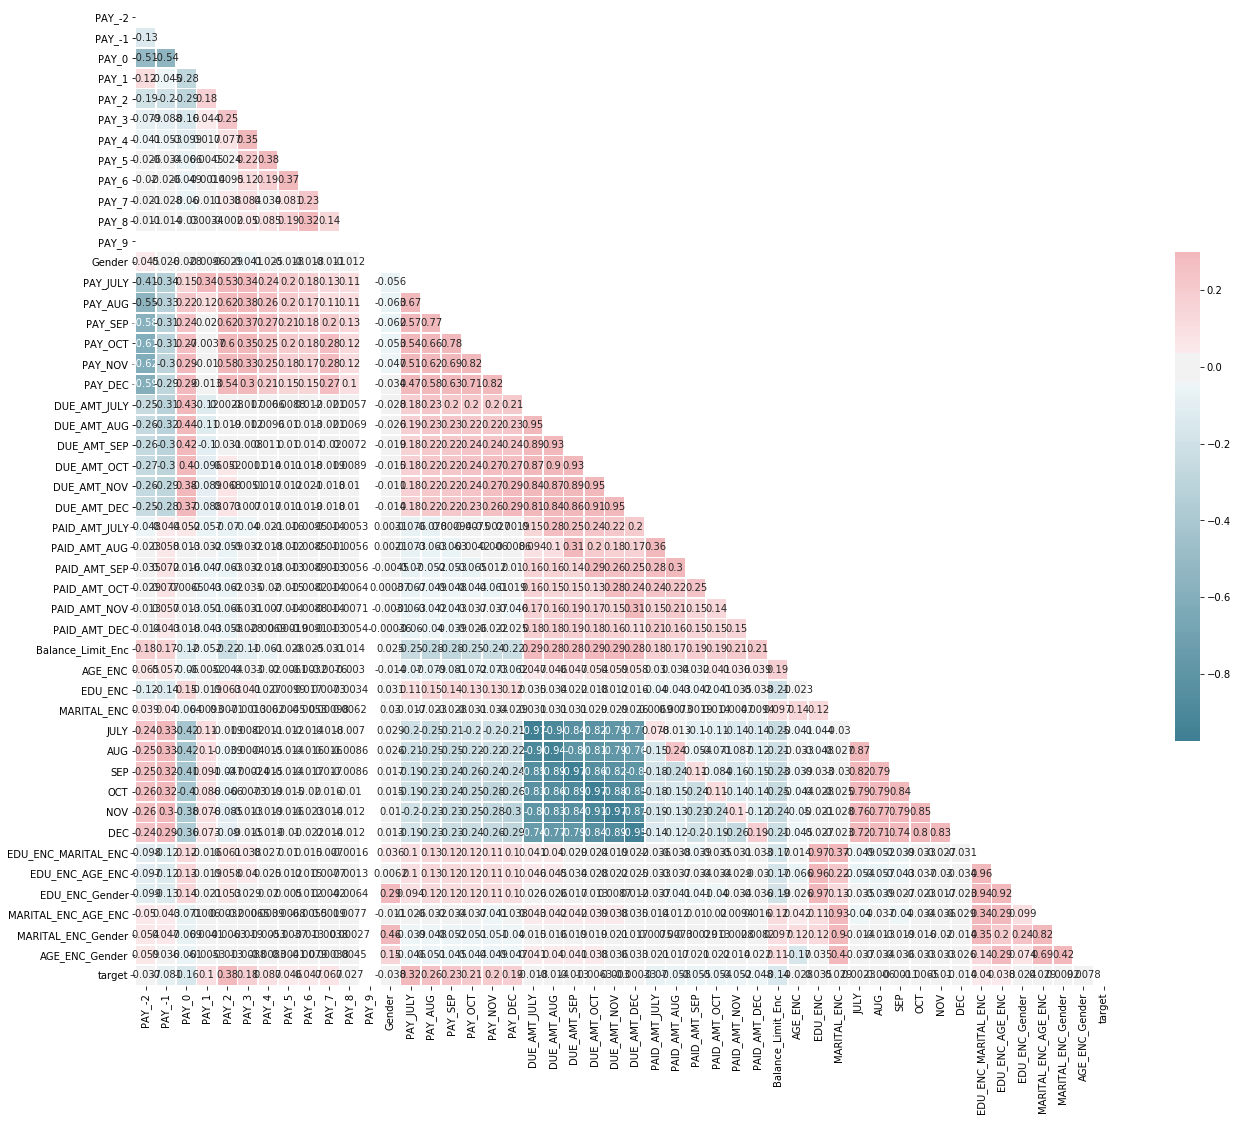

In [144]:
corr = X_train_copy.assign(target = pd.DataFrame(y_train)['NEXT_MONTH_DEFAULT']).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Features selected using models, chi-squared etc. (The code is in another notebook)

### Checking Feature Importance

Code modified from [here](https://mlwhiz.com/blog/2019/08/07/feature_selection/)

In [145]:


num_feats = 20
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_train_copy, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train_copy.loc[:,embeded_lr_support].columns.tolist()

print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

20 selected features
['PAY_-2', 'PAY_0', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_7', 'Gender', 'PAY_JULY', 'PAY_SEP', 'PAY_OCT', 'DUE_AMT_JULY', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'PAID_AMT_JULY', 'PAID_AMT_AUG', 'Balance_Limit_Enc', 'SEP', 'OCT', 'MARITAL_ENC_AGE_ENC']


In [146]:


embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X_train_copy, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train_copy.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_lr_feature)

20 selected features
['PAY_-2', 'PAY_0', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_7', 'Gender', 'PAY_JULY', 'PAY_SEP', 'PAY_OCT', 'DUE_AMT_JULY', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'PAID_AMT_JULY', 'PAID_AMT_AUG', 'Balance_Limit_Enc', 'SEP', 'OCT', 'MARITAL_ENC_AGE_ENC']


In [147]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train_copy, y_train,num_feats)
print(str(len(cor_feature)), 'selected features')

20 selected features


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [148]:

X_norm = MinMaxScaler().fit_transform(X_train_copy)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train_copy.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

20 selected features


In [149]:

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_copy.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 47 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 37 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 27 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


20 selected features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [150]:


lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X_train_copy, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train_copy.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

18 selected features


In [153]:
 feature_name = X_train_copy.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

feature_selection_df.head(17).Feature.tolist()

['PAY_JULY',
 'PAY_2',
 'PAID_AMT_JULY',
 'PAID_AMT_AUG',
 'SEP',
 'PAY_OCT',
 'PAY_7',
 'PAY_3',
 'PAY_1',
 'PAY_0',
 'PAID_AMT_SEP',
 'PAID_AMT_OCT',
 'PAID_AMT_NOV',
 'PAID_AMT_DEC',
 'OCT',
 'DUE_AMT_OCT',
 'Balance_Limit_Enc']